In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [1]:
import librosa
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import IPython.display as ipd
import librosa.display
import scipy
import glob
import numpy as np
import math
import warnings
import pickle
from sklearn.utils import shuffle
import zipfile
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 464655988959239242]

In [3]:
tf.random.set_random_seed(999)
np.random.seed(999)

In [ ]:
# 下载压缩文件，用不上，执行时直接跳过
!wget 'cdn.daitan.com/dataset.zip'

In [ ]:
# 解压文件，用不上，执行时直接跳过
dataset_file_name = './dataset.zip'
with zipfile.ZipFile(dataset_file_name, 'r') as zip_ref:
    zip_ref.extractall('./dataset')

In [4]:
# 设置路径
path_to_dataset = "./dataset/tfrecords"

In [5]:
# get training and validation tf record file names
# 获取验证集和训练集的文件
train_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset, 'train_*'))
val_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset, 'val_*'))

# 打乱
# suffle the file names for training
np.random.shuffle(train_tfrecords_filenames)
print("Training file names: ", train_tfrecords_filenames)
print("Validation file names: ", val_tfrecords_filenames)

Training file names:  ['./dataset/tfrecords\\train_0.tfrecords']
Validation file names:  ['./dataset/tfrecords\\val_0.tfrecords']


In [6]:
# 设置窗口大小，采样率等
windowLength = 256
overlap      = round(0.25 * windowLength) # overlap of 75%
ffTLength    = windowLength #窗函数的宽度
inputFs      = 48e3 #输入的帧数
fs           = 16e3 #采样率
numFeatures  = ffTLength//2 + 1 
numSegments  = 8
print("windowLength:",windowLength)
print("overlap:",overlap)
print("ffTLength:",ffTLength)
print("inputFs:",inputFs)
print("fs:",fs)
print("numFeatures:",numFeatures)
print("numSegments:",numSegments)

windowLength: 256
overlap: 64
ffTLength: 256
inputFs: 48000.0
fs: 16000.0
numFeatures: 129
numSegments: 8


In [7]:
# 设置测试的纯净语音和噪声的路径
mozilla_basepath = "./dataset/en"
UrbanSound8K_basepath = './dataset/UrbanSound8K'

## Prepare Input features

In [8]:
# 从数据集tfrecords中按照键值对提取处数据（将二进制转成能够训练的数据）
def tf_record_parser(record):
    keys_to_features = {
        "noise_stft_phase": tf.io.FixedLenFeature((), tf.string, default_value=""),
        'noise_stft_mag_features': tf.io.FixedLenFeature([], tf.string),
        "clean_stft_magnitude": tf.io.FixedLenFeature((), tf.string)
    }

    features = tf.io.parse_single_example(record, keys_to_features)
# 将字符串的字节重新解释为数字向量
    noise_stft_mag_features = tf.io.decode_raw(features['noise_stft_mag_features'], tf.float32)
    clean_stft_magnitude = tf.io.decode_raw(features['clean_stft_magnitude'], tf.float32)
    noise_stft_phase = tf.io.decode_raw(features['noise_stft_phase'], tf.float32)
    print(noise_stft_mag_features)
    # reshape input and annotation images
    noise_stft_mag_features = tf.reshape(noise_stft_mag_features, (129, 8, 1), name="noise_stft_mag_features")
    clean_stft_magnitude = tf.reshape(clean_stft_magnitude, (129, 1, 1), name="clean_stft_magnitude")
    noise_stft_phase = tf.reshape(noise_stft_phase, (129,), name="noise_stft_phase")
# 返回的是4000 * 201 = 804000 个(129,8,1),(129,1,1)的数据
    return noise_stft_mag_features, clean_stft_magnitude

## Create tf.Data.Dataset

In [9]:
# 训练集，设置shuffle缓冲区大小和batch_size，repeat重复的次数，repeat（1）表示重复一次取数据，repeat（）表示可以重复无数次取数据
train_dataset = tf.data.TFRecordDataset([train_tfrecords_filenames])
print(train_dataset)
train_dataset = train_dataset.map(tf_record_parser)
train_dataset = train_dataset.shuffle(892)
train_dataset = train_dataset.repeat()
print(train_dataset)
train_dataset = train_dataset.batch(512)
print(train_dataset)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# 
print(train_dataset)

<TFRecordDatasetV1 shapes: (), types: tf.string>
Tensor("DecodeRaw:0", shape=(?,), dtype=float32)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
<DatasetV1Adapter shapes: ((129, 8, 1), (129, 1, 1)), types: (tf.float32, tf.float32)>
<DatasetV1Adapter shapes: ((?, 129, 8, 1), (?, 129, 1, 1)), types: (tf.float32, tf.float32)>
<DatasetV1Adapter shapes: ((?, 129, 8, 1), (?, 129, 1, 1)), types: (tf.float32, tf.float32)>


In [10]:
# 同上，设置训练集的重复次数和batch_size
test_dataset = test_dataset.map(tf_record_parser)
test_dataset = test_dataset.repeat(1)
test_dataset = test_dataset.batch(512)

Tensor("DecodeRaw:0", shape=(?,), dtype=float32)


## Model Training

In [11]:
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, Flatten, Dense, Reshape, Conv2DTranspose, BatchNormalization, Activation
from tensorflow.keras import Model, Sequential

In [12]:
# 卷积块，没有用上，可以直接跳过
def conv_block(x, filters, kernel_size, strides, padding='same', use_bn=True):
  x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(0.0006))(x)
  x = Activation('relu')(x)
  if use_bn:
    x = BatchNormalization()(x)
  return x

In [13]:
# 激活函数块，没有用上，可以直接跳过
def full_pre_activation_block(x, filters, kernel_size, strides, padding='same', use_bn=True):
  shortcut = x
  in_channels = x.shape[-1]

  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)

  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters=in_channels, kernel_size=kernel_size, strides=strides, padding='same')(x)

  return shortcut + x

In [14]:
# 创建模型，用以训练
def build_model(l2_strength):
  inputs = Input(shape=[numFeatures,numSegments,1])
  x = inputs

  # -----输入是一个（129，8）的大小，先padding成（137，8）大小，再用（9，8）核valid方式卷完就成了（129，1）了
  x = tf.keras.layers.ZeroPadding2D(((4,4), (0,0)))(x)
  x = Conv2D(filters=18, kernel_size=[9,8], strides=[1, 1], padding='valid', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)
#  （129，1）same方式卷积还是（129，1），以下皆是该形状，只是卷积核大小和卷积核个数不同
  skip0 = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
                 kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(skip0)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # -----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  skip1 = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
                 kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(skip1)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # ----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)
  
  x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # ----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
             kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = x + skip1
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # ----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
             kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = x + skip0
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # ----
  x = tf.keras.layers.SpatialDropout2D(0.2)(x)
  x = Conv2D(filters=1, kernel_size=[129,1], strides=[1, 1], padding='same')(x)

  model = Model(inputs=inputs, outputs=x)

  optimizer = tf.keras.optimizers.Adam(3e-4)
  #optimizer = RAdam(total_steps=10000, warmup_proportion=0.1, min_lr=3e-4)

  model.compile(optimizer=optimizer, loss='mse', 
                metrics=[tf.keras.metrics.RootMeanSquaredError('rmse')])
  return model

In [19]:
model = build_model(l2_strength=0.0)
# 
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 129, 8, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 137, 8, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 129, 1, 18)   1296        zero_padding2d[0][0]             
__________________________________________________________________________________________________
activation (Activation)         (None, 129, 1, 18)   0           conv2d[0][

In [16]:
# You might need to install the following dependencies: sudo apt install python-pydot python-pydot-ng graphviz
# 画图，缺少包画不了，不影响训练
import pydot
tf.keras.utils.plot_model(model, show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [17]:
# tensorboard显示训练过程和模型
%tensorboard --logdir logs

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 9212.

In [16]:
# 先评估一下模型
baseline_val_loss = model.evaluate(test_dataset)[0]
print(f"Baseline accuracy {baseline_val_loss}")

    182/Unknown - 1s 790ms/step - loss: 0.4623 - rmse: 0.679 - 1s 582ms/step - loss: 0.4807 - rmse: 0.693 - 2s 513ms/step - loss: 0.5947 - rmse: 0.771 - 2s 475ms/step - loss: 0.5929 - rmse: 0.770 - 2s 455ms/step - loss: 0.5638 - rmse: 0.750 - 3s 443ms/step - loss: 0.5605 - rmse: 0.748 - 3s 437ms/step - loss: 0.5789 - rmse: 0.760 - 3s 429ms/step - loss: 0.5644 - rmse: 0.751 - 4s 428ms/step - loss: 0.5501 - rmse: 0.741 - 4s 425ms/step - loss: 0.5383 - rmse: 0.733 - 5s 419ms/step - loss: 0.5305 - rmse: 0.728 - 5s 414ms/step - loss: 0.5218 - rmse: 0.722 - 5s 411ms/step - loss: 0.5209 - rmse: 0.721 - 6s 409ms/step - loss: 0.5206 - rmse: 0.721 - 6s 408ms/step - loss: 0.5421 - rmse: 0.736 - 7s 407ms/step - loss: 0.5490 - rmse: 0.740 - 7s 411ms/step - loss: 0.5445 - rmse: 0.737 - 7s 412ms/step - loss: 0.5382 - rmse: 0.733 - 8s 411ms/step - loss: 0.5415 - rmse: 0.735 - 8s 412ms/step - loss: 0.5429 - rmse: 0.736 - 9s 410ms/step - loss: 0.5589 - rmse: 0.747 - 9s 409ms/step - loss: 0.5571 - rmse: 

    359/Unknown - 71s 386ms/step - loss: 0.5445 - rmse: 0.73 - 71s 386ms/step - loss: 0.5446 - rmse: 0.73 - 71s 386ms/step - loss: 0.5443 - rmse: 0.73 - 72s 386ms/step - loss: 0.5455 - rmse: 0.73 - 72s 386ms/step - loss: 0.5465 - rmse: 0.73 - 73s 386ms/step - loss: 0.5458 - rmse: 0.73 - 73s 386ms/step - loss: 0.5457 - rmse: 0.73 - 73s 387ms/step - loss: 0.5454 - rmse: 0.73 - 74s 387ms/step - loss: 0.5453 - rmse: 0.73 - 74s 387ms/step - loss: 0.5448 - rmse: 0.73 - 75s 387ms/step - loss: 0.5450 - rmse: 0.73 - 75s 387ms/step - loss: 0.5445 - rmse: 0.73 - 76s 388ms/step - loss: 0.5457 - rmse: 0.73 - 76s 388ms/step - loss: 0.5453 - rmse: 0.73 - 76s 388ms/step - loss: 0.5449 - rmse: 0.73 - 77s 388ms/step - loss: 0.5447 - rmse: 0.73 - 77s 388ms/step - loss: 0.5443 - rmse: 0.73 - 78s 389ms/step - loss: 0.5448 - rmse: 0.73 - 78s 389ms/step - loss: 0.5451 - rmse: 0.73 - 79s 389ms/step - loss: 0.5450 - rmse: 0.73 - 79s 390ms/step - loss: 0.5447 - rmse: 0.73 - 80s 390ms/step - loss: 0.5448 - rmse:

    393/Unknown - 148s 411ms/step - loss: 0.5520 - rmse: 0.743 - 148s 411ms/step - loss: 0.5518 - rmse: 0.742 - 149s 411ms/step - loss: 0.5518 - rmse: 0.742 - 149s 411ms/step - loss: 0.5516 - rmse: 0.742 - 150s 411ms/step - loss: 0.5520 - rmse: 0.743 - 150s 411ms/step - loss: 0.5518 - rmse: 0.742 - 150s 411ms/step - loss: 0.5516 - rmse: 0.742 - 151s 411ms/step - loss: 0.5517 - rmse: 0.742 - 151s 411ms/step - loss: 0.5515 - rmse: 0.742 - 152s 411ms/step - loss: 0.5514 - rmse: 0.742 - 152s 411ms/step - loss: 0.5512 - rmse: 0.742 - 152s 411ms/step - loss: 0.5509 - rmse: 0.742 - 153s 411ms/step - loss: 0.5509 - rmse: 0.742 - 153s 411ms/step - loss: 0.5507 - rmse: 0.742 - 154s 411ms/step - loss: 0.5510 - rmse: 0.742 - 154s 411ms/step - loss: 0.5510 - rmse: 0.742 - 154s 411ms/step - loss: 0.5510 - rmse: 0.742 - 155s 410ms/step - loss: 0.5511 - rmse: 0.742 - 155s 410ms/step - loss: 0.5514 - rmse: 0.742 - 155s 410ms/step - loss: 0.5515 - rmse: 0.742 - 156s 410ms/step - loss: 0.5515 - rmse: 0.7

In [15]:
def l2_norm(vector):
    return np.square(vector)
# 计算信噪比，作者写了没用上
def SDR(denoised, cleaned, eps=1e-7): # Signal to Distortion Rationp.mean
    a = l2_norm(denoised)
    b = l2_norm(denoised - cleaned)
    a_b = a / b
    return np.mean(10 * np.log10(a_b + eps))
print(train_dataset)

<DatasetV1Adapter shapes: ((?, 129, 8, 1), (?, 129, 1, 1)), types: (tf.float32, tf.float32)>


In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, baseline=None)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, update_freq='batch')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='./denoiser_cnn_log_mel_generator.h5', 
                                                         monitor='val_loss', save_best_only=True)
# 训练模型
model.fit(train_dataset,
#           batch_size = 512,
         steps_per_epoch=786, # 每次用完所有的数据需要经历多少个batch_size. steps_per_epoch = datasize/batch_size
         validation_steps=393, #只有steps_per_epoch有值时validation_steps才有意义，即验证集需要多少个batch_size能遍历完所有的验证集
         validation_data=test_dataset,
         epochs=10, #一个epochs表示把所有数据都用一遍训练，epochs表示将所有数据用多少次
#          callbacks=[early_stopping_callback, tensorboard_callback, checkpoint_callback]
        )

Epoch 1/10
194/786 [======>.......................] - ETA: 1:02:18 - loss: 0.2232 - rmse: 0.472 - ETA: 49:31 - loss: 0.2297 - rmse: 0.4793  - ETA: 47:10 - loss: 0.2349 - rmse: 0.484 - ETA: 45:31 - loss: 0.2336 - rmse: 0.483 - ETA: 43:46 - loss: 0.2295 - rmse: 0.479 - ETA: 42:33 - loss: 0.2263 - rmse: 0.475 - ETA: 41:56 - loss: 0.2227 - rmse: 0.471 - ETA: 41:27 - loss: 0.2207 - rmse: 0.469 - ETA: 41:02 - loss: 0.2180 - rmse: 0.466 - ETA: 40:39 - loss: 0.2168 - rmse: 0.465 - ETA: 40:13 - loss: 0.2164 - rmse: 0.465 - ETA: 39:45 - loss: 0.2168 - rmse: 0.465 - ETA: 39:27 - loss: 0.2170 - rmse: 0.465 - ETA: 39:12 - loss: 0.2164 - rmse: 0.465 - ETA: 39:00 - loss: 0.2171 - rmse: 0.465 - ETA: 38:55 - loss: 0.2200 - rmse: 0.469 - ETA: 38:45 - loss: 0.2202 - rmse: 0.469 - ETA: 38:29 - loss: 0.2191 - rmse: 0.468 - ETA: 38:17 - loss: 0.2180 - rmse: 0.466 - ETA: 38:05 - loss: 0.2176 - rmse: 0.466 - ETA: 37:50 - loss: 0.2158 - rmse: 0.464 - ETA: 37:37 - loss: 0.2145 - rmse: 0.463 - ETA: 37:32 - loss:

195/786 [======>.......................] - ETA: 32:36 - loss: 0.2290 - rmse: 0.478 - ETA: 32:44 - loss: 0.2180 - rmse: 0.466 - ETA: 33:22 - loss: 0.2148 - rmse: 0.463 - ETA: 34:16 - loss: 0.2083 - rmse: 0.456 - ETA: 35:07 - loss: 0.2027 - rmse: 0.450 - ETA: 35:23 - loss: 0.1981 - rmse: 0.445 - ETA: 36:23 - loss: 0.1953 - rmse: 0.441 - ETA: 37:22 - loss: 0.1925 - rmse: 0.438 - ETA: 38:27 - loss: 0.1907 - rmse: 0.436 - ETA: 38:44 - loss: 0.1911 - rmse: 0.437 - ETA: 39:14 - loss: 0.1921 - rmse: 0.438 - ETA: 39:20 - loss: 0.1934 - rmse: 0.439 - ETA: 39:32 - loss: 0.1928 - rmse: 0.439 - ETA: 39:31 - loss: 0.1933 - rmse: 0.439 - ETA: 39:17 - loss: 0.1953 - rmse: 0.441 - ETA: 39:05 - loss: 0.1947 - rmse: 0.441 - ETA: 38:51 - loss: 0.1945 - rmse: 0.441 - ETA: 38:35 - loss: 0.1934 - rmse: 0.439 - ETA: 38:19 - loss: 0.1934 - rmse: 0.439 - ETA: 38:08 - loss: 0.1916 - rmse: 0.437 - ETA: 37:57 - loss: 0.1901 - rmse: 0.436 - ETA: 37:45 - loss: 0.1896 - rmse: 0.435 - ETA: 37:32 - loss: 0.1900 - rmse:

In [21]:
val_loss = model.evaluate(test_dataset)[0]
if val_loss < baseline_val_loss:
  print("New model saved.")#保存模型
#   model.save('./denoiser_cnn_log_mel_generator.h5')
# 保存模型会报错TypeError: ('Not JSON Serializable:'
# 所以采用下面的保存权重的方式
  model.save_weights('./denoiser_cnn_log_mel_generator.h5')

    182/Unknown - 1s 640ms/step - loss: 0.0573 - rmse: 0.239 - 1s 487ms/step - loss: 0.1003 - rmse: 0.316 - 1s 442ms/step - loss: 0.1232 - rmse: 0.351 - 2s 415ms/step - loss: 0.1213 - rmse: 0.348 - 2s 399ms/step - loss: 0.1128 - rmse: 0.335 - 2s 388ms/step - loss: 0.1173 - rmse: 0.342 - 3s 381ms/step - loss: 0.1198 - rmse: 0.346 - 3s 376ms/step - loss: 0.1224 - rmse: 0.349 - 3s 371ms/step - loss: 0.1206 - rmse: 0.347 - 4s 368ms/step - loss: 0.1202 - rmse: 0.346 - 4s 365ms/step - loss: 0.1179 - rmse: 0.343 - 4s 363ms/step - loss: 0.1135 - rmse: 0.336 - 5s 361ms/step - loss: 0.1133 - rmse: 0.336 - 5s 360ms/step - loss: 0.1142 - rmse: 0.337 - 5s 359ms/step - loss: 0.1192 - rmse: 0.345 - 6s 357ms/step - loss: 0.1174 - rmse: 0.342 - 6s 356ms/step - loss: 0.1158 - rmse: 0.340 - 6s 356ms/step - loss: 0.1168 - rmse: 0.341 - 7s 354ms/step - loss: 0.1179 - rmse: 0.343 - 7s 354ms/step - loss: 0.1169 - rmse: 0.341 - 7s 353ms/step - loss: 0.1231 - rmse: 0.350 - 8s 352ms/step - loss: 0.1234 - rmse: 

    361/Unknown - 62s 341ms/step - loss: 0.1251 - rmse: 0.35 - 63s 341ms/step - loss: 0.1252 - rmse: 0.35 - 63s 341ms/step - loss: 0.1252 - rmse: 0.35 - 63s 341ms/step - loss: 0.1252 - rmse: 0.35 - 64s 341ms/step - loss: 0.1254 - rmse: 0.35 - 64s 341ms/step - loss: 0.1251 - rmse: 0.35 - 65s 341ms/step - loss: 0.1250 - rmse: 0.35 - 65s 341ms/step - loss: 0.1249 - rmse: 0.35 - 65s 341ms/step - loss: 0.1251 - rmse: 0.35 - 66s 341ms/step - loss: 0.1250 - rmse: 0.35 - 66s 342ms/step - loss: 0.1250 - rmse: 0.35 - 66s 342ms/step - loss: 0.1248 - rmse: 0.35 - 67s 342ms/step - loss: 0.1248 - rmse: 0.35 - 67s 342ms/step - loss: 0.1247 - rmse: 0.35 - 67s 342ms/step - loss: 0.1246 - rmse: 0.35 - 68s 342ms/step - loss: 0.1244 - rmse: 0.35 - 68s 342ms/step - loss: 0.1245 - rmse: 0.35 - 68s 342ms/step - loss: 0.1247 - rmse: 0.35 - 69s 342ms/step - loss: 0.1249 - rmse: 0.35 - 69s 342ms/step - loss: 0.1249 - rmse: 0.35 - 69s 342ms/step - loss: 0.1250 - rmse: 0.35 - 70s 342ms/step - loss: 0.1249 - rmse:

    393/Unknown - 126s 348ms/step - loss: 0.1265 - rmse: 0.355 - 126s 348ms/step - loss: 0.1265 - rmse: 0.355 - 127s 348ms/step - loss: 0.1267 - rmse: 0.355 - 127s 348ms/step - loss: 0.1267 - rmse: 0.355 - 127s 348ms/step - loss: 0.1266 - rmse: 0.355 - 128s 348ms/step - loss: 0.1266 - rmse: 0.355 - 128s 348ms/step - loss: 0.1264 - rmse: 0.355 - 128s 348ms/step - loss: 0.1265 - rmse: 0.355 - 129s 348ms/step - loss: 0.1266 - rmse: 0.355 - 129s 348ms/step - loss: 0.1265 - rmse: 0.355 - 129s 348ms/step - loss: 0.1266 - rmse: 0.355 - 130s 348ms/step - loss: 0.1265 - rmse: 0.355 - 130s 348ms/step - loss: 0.1265 - rmse: 0.355 - 130s 348ms/step - loss: 0.1265 - rmse: 0.355 - 131s 348ms/step - loss: 0.1266 - rmse: 0.355 - 131s 348ms/step - loss: 0.1266 - rmse: 0.355 - 132s 348ms/step - loss: 0.1267 - rmse: 0.355 - 132s 348ms/step - loss: 0.1268 - rmse: 0.356 - 132s 348ms/step - loss: 0.1268 - rmse: 0.356 - 133s 348ms/step - loss: 0.1267 - rmse: 0.355 - 133s 348ms/step - loss: 0.1268 - rmse: 0.3

TypeError: ('Not JSON Serializable:', b'\n\x03add\x12\x03Add\x1a\x10conv2d_10/Conv2D\x1a\x0fconv2d_4/Conv2D*\x07\n\x01T\x12\x020\x01')

## Testing

In [1]:
# 读取语音文件，将语音文件转成np.array
def read_audio(filepath, sample_rate, normalize=True):
    """Read an audio file and return it as a numpy array"""
    audio, sr = librosa.load(filepath, sr=sample_rate)
    if normalize:
      div_fac = 1 / np.max(np.abs(audio)) / 3.0
      audio = audio * div_fac
    return audio, sr
# 加噪声，将噪声与纯净语音相加
def add_noise_to_clean_audio(clean_audio, noise_signal):
    """Adds noise to an audio sample"""
    if len(clean_audio) >= len(noise_signal):
        # print("The noisy signal is smaller than the clean audio input. Duplicating the noise.")
        while len(clean_audio) >= len(noise_signal):
            noise_signal = np.append(noise_signal, noise_signal)

    ## Extract a noise segment from a random location in the noise file
    ind = np.random.randint(0, noise_signal.size - clean_audio.size)

    noiseSegment = noise_signal[ind: ind + clean_audio.size]

#     speech_power = np.sum(clean_audio ** 2)
#     noise_power = np.sum(noiseSegment ** 2)
#     不采用平方和能量比值的形式，直接加20倍的噪声
    noisyAudio = clean_audio + 20 * noiseSegment
    return noisyAudio

# 播放语音
def play(audio, sample_rate):
    ipd.display(ipd.Audio(data=audio, rate=sample_rate))  # load a local WAV file
    
# 自己写的加噪声方法，按照信噪比的方式加噪声
def add_noise(clean, noise, snr):
#     if len(noise) > len(clean):
#         noise = noise[:len(clean)]
#     else:
#         times = len(clean) // len(noise)
#         noise = np.tile(noise, times)
#         padding = [0] * (len(clean) - len(noise))
#         noise = np.hstack([noise, padding])
 
    noise = (norm(clean) / (10.0 ** (0.1 * snr))*norm(noise))** 0.5
    mix = clean + noise
    return mix

def norm(vector):
    return np.square(vector)

In [2]:
# 特征提取
class FeatureExtractor:
    def __init__(self, audio, *, windowLength, overlap, sample_rate):
        self.audio = audio
        self.ffT_length = windowLength
        self.window_length = windowLength
        self.overlap = overlap
        self.sample_rate = sample_rate
        self.window = scipy.signal.hamming(self.window_length, sym=False)
# 短时傅里叶变换
    def get_stft_spectrogram(self):
        return librosa.stft(self.audio, n_fft=self.ffT_length, win_length=self.window_length, hop_length=self.overlap,
                            window=self.window, center=True)
# 短时傅里叶逆变换
    def get_audio_from_stft_spectrogram(self, stft_features):
        return librosa.istft(stft_features, win_length=self.window_length, hop_length=self.overlap,
                             window=self.window, center=True)
# 梅尔频谱倒数和下面的逆梅尔没有用上
    def get_mel_spectrogram(self):
        return librosa.feature.melspectrogram(self.audio, sr=self.sample_rate, power=2.0, pad_mode='reflect',
                                           n_fft=self.ffT_length, hop_length=self.overlap, center=True)

    def get_audio_from_mel_spectrogram(self, M):
        return librosa.feature.inverse.mel_to_audio(M, sr=self.sample_rate, n_fft=self.ffT_length, hop_length=self.overlap,
                                             win_length=self.window_length, window=self.window,
                                             center=True, pad_mode='reflect', power=2.0, n_iter=32, length=None)

In [ ]:
# from keras.models import load_model
# 从训练好的模型中加载模型，加载模型会保存，使用下一行的先加载网络结构再加载权重的方法
# model = load_model('denoiser_cnn_log_mel_generator.h5')  #选取自己的.h5模型名称

# 先构造网络模型
model = build_model(l2_strength=0.0)
# 加载权重
model.load_weights('denoiser_cnn_log_mel_generator.h5')

In [5]:
# 读取纯净语音
cleanAudio, sr = read_audio(os.path.join(mozilla_basepath, 'test', 'common_voice_zh-CN_18531539.mp3'), sample_rate=fs)
# cleanAudio, sr = read_audio(os.path.join(mozilla_basepath, 'test', 'common_voice_en_16526.mp3'), sample_rate=fs)
print("Min:", np.min(cleanAudio),"Max:",np.max(cleanAudio))
print(cleanAudio.shape)
ipd.Audio(data=cleanAudio, rate=sr) # load a local WAV file

# 画出纯净语音的时域图
# f, (ax1) = plt.subplots(1, 1, sharey=True)

# ax1.plot(cleanAudio)
# ax1.set_title("Clean Audio")

ValueError: Cannot create group in read-only mode.

In [23]:
# 读取噪声
noiseAudio, sr = read_audio(os.path.join(UrbanSound8K_basepath, 'test', '120-32_3_Point1.wav'), sample_rate=fs)
# noiseAudio, sr = read_audio(os.path.join(UrbanSound8K_basepath, 'test', '7913-3-0-0.wav'), sample_rate=fs)
# noiseAudio, sr = read_audio(os.path.join(UrbanSound8K_basepath, 'test', '134717-0-0-22.wav'), sample_rate=fs)
print("Min:", np.min(noiseAudio),"Max:",np.max(noiseAudio))
ipd.Audio(data=noiseAudio, rate=sr) # load a local WAV file

# 画出噪声的时域图
# f, (ax1) = plt.subplots(1, 1, sharey=True)

# ax1.plot(noisyAudio)
# ax1.set_title("Noisy Audio")

Min: -0.33333334 Max: 0.2476769


In [24]:
# 纯净语音特征提取，傅里叶变换，变成能够进行卷积的维度
cleanAudioFeatureExtractor = FeatureExtractor(cleanAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
stft_features = cleanAudioFeatureExtractor.get_stft_spectrogram()
stft_features = np.abs(stft_features)
print("Min:", np.min(stft_features),"Max:",np.max(stft_features))

Min: 0.0 Max: 9.687799


In [27]:
noisyAudio = add_noise_to_clean_audio(cleanAudio, noiseAudio)
# noisyAudio = add_noise(cleanAudio, noiseAudio, -15)


# 按照下面的add_noise加噪声之前需要将语音和噪声对其，下面是对其的操作
# if len(cleanAudio) >= len(noiseAudio):
#         # print("The noisy signal is smaller than the clean audio input. Duplicating the noise.")
#         while len(cleanAudio) >= len(noiseAudio):
#             noiseAudio = np.append(noiseAudio, noiseAudio)

#     ## Extract a noise segment from a random location in the noise file
# ind = np.random.randint(0, noiseAudio.size - cleanAudio.size)

# noiseSegment = noiseAudio[ind: ind + cleanAudio.size]
# print(SDR(cleanAudio, noiseSegment))

# 下面的加噪声是自己写的按照信噪比加噪声
# noisyAudio = add_noise(cleanAudio, noiseSegment, -20)

ipd.Audio(data=noisyAudio, rate=fs) # load a local WAV file

# 画出频率图像
# f, (ax1, ax2) = plt.subplots(2, 1, sharey=True)

# ax1.plot(cleanAudio)
# ax1.set_title("Clean Audio")

# ax2.plot(noisyAudio)
# ax2.set_title("Noisy Audio")

In [121]:
def prepare_input_features(stft_features):
    # Phase Aware Scaling: To avoid extreme differences (more than
    # 45 degree) between the noisy and clean phase, the clean spectral magnitude was encoded as similar to [21]:
    noisySTFT = np.concatenate([stft_features[:,0:numSegments-1], stft_features], axis=1)
    stftSegments = np.zeros((numFeatures, numSegments , noisySTFT.shape[1] - numSegments + 1))

    for index in range(noisySTFT.shape[1] - numSegments + 1):
        stftSegments[:,:,index] = noisySTFT[:,index:index + numSegments]
    return stftSegments

In [122]:
noiseAudioFeatureExtractor = FeatureExtractor(noisyAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
noise_stft_features = noiseAudioFeatureExtractor.get_stft_spectrogram()

# Paper: Besides, spectral phase was not used in the training phase.
# At reconstruction, noisy spectral phase was used instead to
# perform in- verse STFT and recover human speech.
noisyPhase = np.angle(noise_stft_features)
print(noisyPhase.shape)
noise_stft_features = np.abs(noise_stft_features)

mean = np.mean(noise_stft_features)
std = np.std(noise_stft_features)
noise_stft_features = (noise_stft_features - mean) / std

(129, 1753)


In [123]:
predictors = prepare_input_features(noise_stft_features)

In [124]:
predictors = np.reshape(predictors, (predictors.shape[0], predictors.shape[1], 1, predictors.shape[2]))
predictors = np.transpose(predictors, (3, 0, 1, 2)).astype(np.float32)
print('predictors.shape:', predictors.shape)

predictors.shape: (1753, 129, 8, 1)


In [125]:
# 关键，使用训练好的模型预测，即降噪过程
STFTFullyConvolutional = model.predict(predictors)
print(STFTFullyConvolutional.shape)

(1753, 129, 1, 1)


In [126]:
# 将特征语谱转成语音
def revert_features_to_audio(features, phase, cleanMean=None, cleanStd=None):
    # scale the outpus back to the original range
    if cleanMean and cleanStd:
        features = cleanStd * features + cleanMean

    phase = np.transpose(phase, (1, 0))
    features = np.squeeze(features)

    # features = librosa.db_to_power(features)
    features = features * np.exp(1j * phase)  # that fixes the abs() ope previously done

    features = np.transpose(features, (1, 0))
    return noiseAudioFeatureExtractor.get_audio_from_stft_spectrogram(features)

In [127]:
denoisedAudioFullyConvolutional = revert_features_to_audio(STFTFullyConvolutional, noisyPhase, mean, std)
print("Min:", np.min(denoisedAudioFullyConvolutional),"Max:",np.max(denoisedAudioFullyConvolutional))
ipd.Audio(data=denoisedAudioFullyConvolutional, rate=fs) # load a local WAV file

Min: -0.15908033 Max: 0.21175766


In [ ]:
# A numeric identifier of the sound class -- Types of noise
# 0 = air_conditioner
# 1 = car_horn
# 2 = children_playing
# 3 = dog_bark
# 4 = drilling
# 5 = engine_idling
# 6 = gun_shot
# 7 = jackhammer
# 8 = siren
# 9 = street_music

Text(0.5, 1.0, 'Denoised Audio')

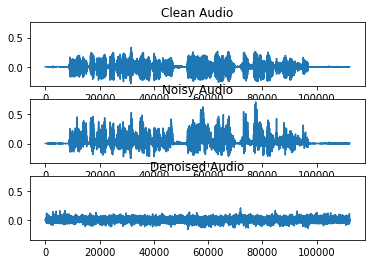

In [128]:
# 画出图像
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)

ax1.plot(cleanAudio)
ax1.set_title("Clean Audio")

ax2.plot(noisyAudio)
ax2.set_title("Noisy Audio")

ax3.plot(denoisedAudioFullyConvolutional)
ax3.set_title("Denoised Audio")